# Data Preparation Notebook

The focus of this notebook is to prepare our data to be used in the modeling notebook. This means: 
- Cleaning the data of all extreme outliers and missing values.
- Data Exploration.
- Feature Engineering to create new columns from exists.
- Export cleaned data to new csv to be used in modeling notebook.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['font.size'] = 12
palette = sns.color_palette('Paired', 10)

## Data Cleaning

In [19]:
train_data = pd.read_csv('train.csv', nrows=4000000)
test_data = pd.read_csv('test.csv') # 9914 observations

train_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [21]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.000000e+06,4.000000e+06,4.000000e+06,3.999971e+06,3.999971e+06,4.000000e+06
mean,1.134395e+01,-7.250844e+01,3.991910e+01,-7.250871e+01,3.991789e+01,1.684334e+00
std,9.824543e+00,1.312180e+01,8.797868e+00,1.289308e+01,9.716855e+00,1.329071e+00
min,-6.200000e+01,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076711e+01,-7.396366e+01,4.076812e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,2.912465e+03,3.457622e+03,3.345917e+03,2.080000e+02


- `fare_amount`: We can see that for we have negative values which should not be possible (most likely due to a recording error). We will want to drop all values that are below 0, and investigate the large gap between the 75th percentile and max value as well.


- `passenger_count`: We can see that we have a passenger count of 208 which will need to be removed. Possibly removing all passenger counts above 6 will generally account for most taxi's capacities.

### Drop Missing Values

In [22]:
train_data.isna().any()

key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude     True
dropoff_latitude      True
passenger_count      False
dtype: bool

In [23]:
missing_dlong = train_data['dropoff_longitude'].isna().sum()
missing_dlat = train_data['dropoff_latitude'].isna().sum()
print(f'Missing Dropoff Long: {missing_dlong}... Missing Dropoff Lat: {missing_dlat}')

Missing Dropoff Long: 29... Missing Dropoff Lat: 29


For `dropoff_longitude` and `dropoff_latitude` we will want to drop all missing values since we cannot find the total distance traveled.

In [24]:
train_data.dropna(axis=0, inplace=True)
train_data.isna().any()

key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count      False
dtype: bool

### Fixing `fare_amount`
We can see most of our data is focused around approximately 0-60, but our outliers have a low of -62 and a high of 1273. Both of these values are very unlikely, so we want to drop all fare amounts below 2 and all fare amount above the .995 quantile (meaning the 99.5th percentile). It is safe to say most of the data is in this remaining range.

Fare amount has a min of -62.0 and a max of 1273.31


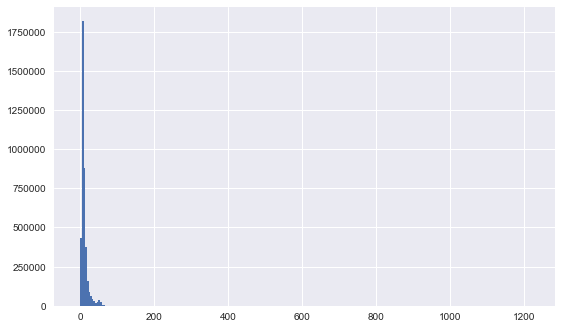

In [25]:
fare_min = train_data.fare_amount.min()
fare_max = train_data.fare_amount.max()
print('Fare amount has a min of {} and a max of {}'.format(fare_min, fare_max))
plt.hist(train_data['fare_amount'], bins=300)
plt.xlim([fare_min-10, fare_max+10])
plt.show()

Fare amount has a min of 2.0 and a max of 57.31


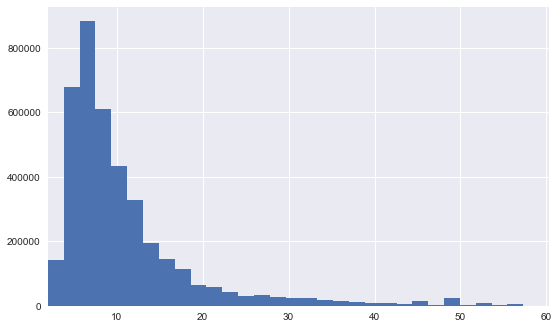

In [26]:
data_fare_fixed = train_data[(train_data.fare_amount < train_data.fare_amount.quantile(.995)) & (train_data.fare_amount >= 2)]

fare_min = data_fare_fixed.fare_amount.min()
fare_max = data_fare_fixed.fare_amount.max()
print('Fare amount has a min of {} and a max of {}'.format(fare_min, fare_max))
plt.hist(data_fare_fixed['fare_amount'], bins=30)
plt.xlim([fare_min, fare_max+3])
plt.show()

We now can see we have a right skew distribution, with a minimum of 2 and a maximum of 57.31. These values are much more likely and the data follows a much more clean distribution after dropping the values specified above.

### Fixing `passenger_count`

We also noticed from the summary statistics table that `passenger_count` has a max value of 208. It is very unlikely that there were this many passenger (most likely due to a recording error). We will want to drop the obsevations with extremly large passenger counts since this will negatively impact our model. We will want to drop all passenger counts over 7 since it is not very likely to have more passengers than this.

In [27]:
data_fare_fixed['passenger_count'].value_counts()

1      2745649
2       584722
5       281204
3       173821
4        84146
6        83222
0        14186
208          5
129          1
Name: passenger_count, dtype: int64

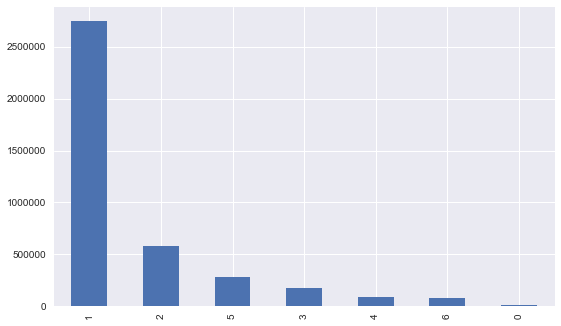

In [28]:
data_p_fixed = data_fare_fixed[data_fare_fixed['passenger_count'] < 7]
data_p_fixed['passenger_count'].value_counts().plot.bar();

## Data Exploration
Note: the last checkpoint for our data was the **data_p_fixed** variable, so that is the one we will start with.

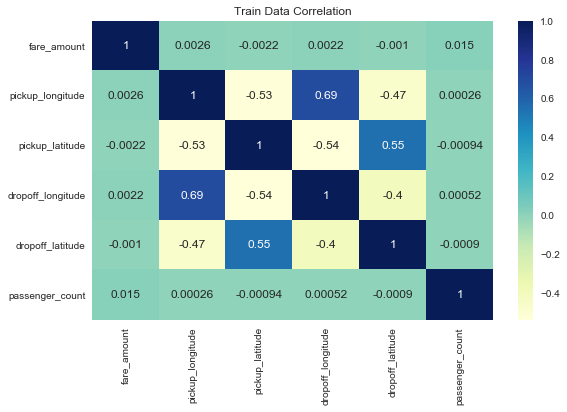

In [29]:
sns.heatmap(data_p_fixed.corr(), annot=True, cmap='YlGnBu').set_title('Train Data Correlation');

There is no clear correlation between `fare_amount` and any other feature in our dataset yet. We can see the corelation between the pickup and dropoff locations, but this is to be expected.

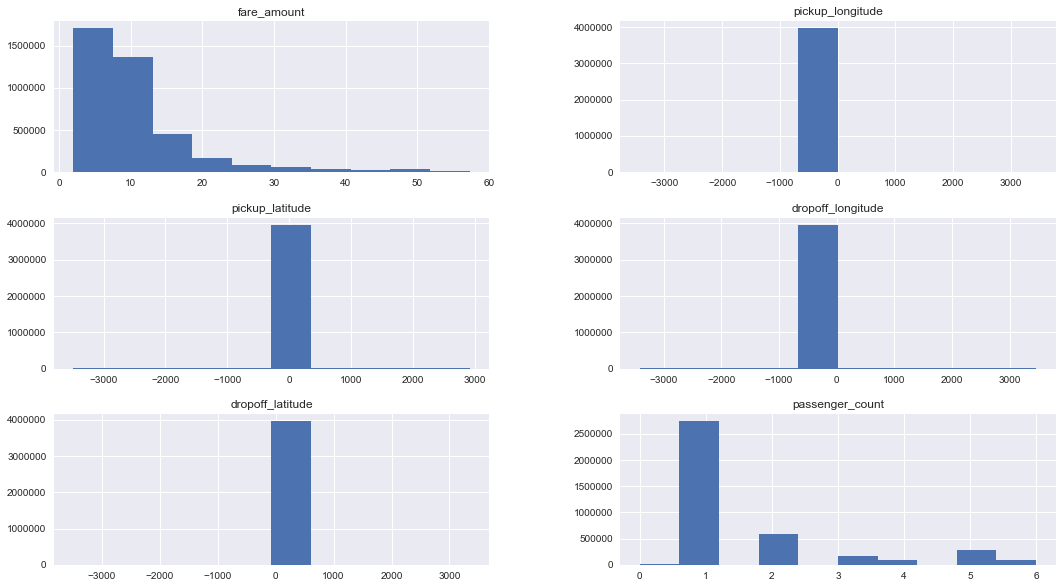

In [30]:
data_p_fixed.hist(figsize=(16,10));

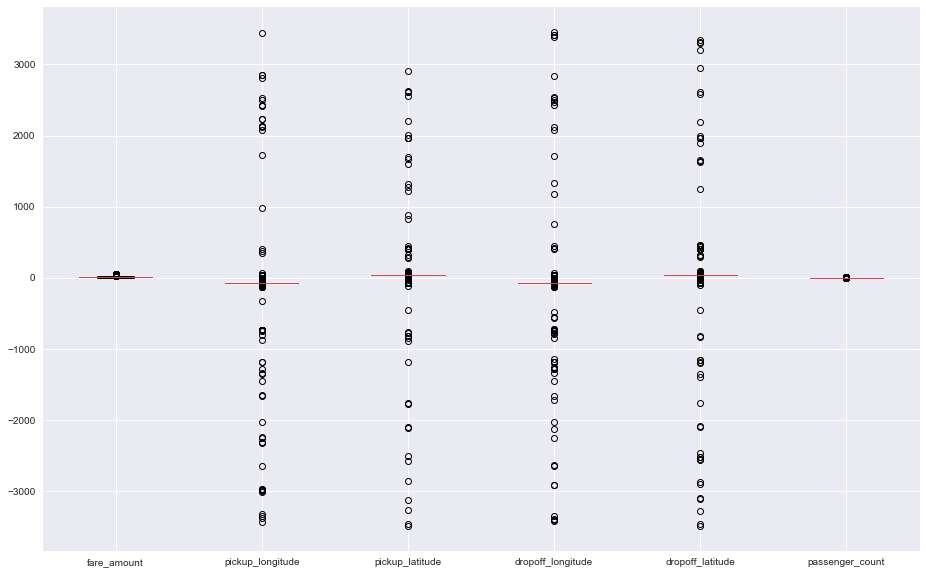

In [31]:
data_p_fixed.boxplot(figsize=(14,10));

### Remove Geographic Extremes
We can see there are outliers present in the latitude and longitude columns. To put it in perspective, New York City has a latitude of 40.730610 and a longitude of -73.935242. We need to remove all outliers. Philidelphia (an entire state over) has a latitude of 39.9526 and a longitude of 75.1652, so we will give the NYC columns a variance of $\pm$2 to be on the safer side (incase it was a very long ride).

In [32]:
plat_mean = data_p_fixed['pickup_latitude'].mean()
plon_mean = data_p_fixed['pickup_longitude'].mean()
dlat_mean = data_p_fixed['dropoff_latitude'].mean()
dlon_mean = data_p_fixed['dropoff_longitude'].mean()

Dropped 84460 geographic extremes


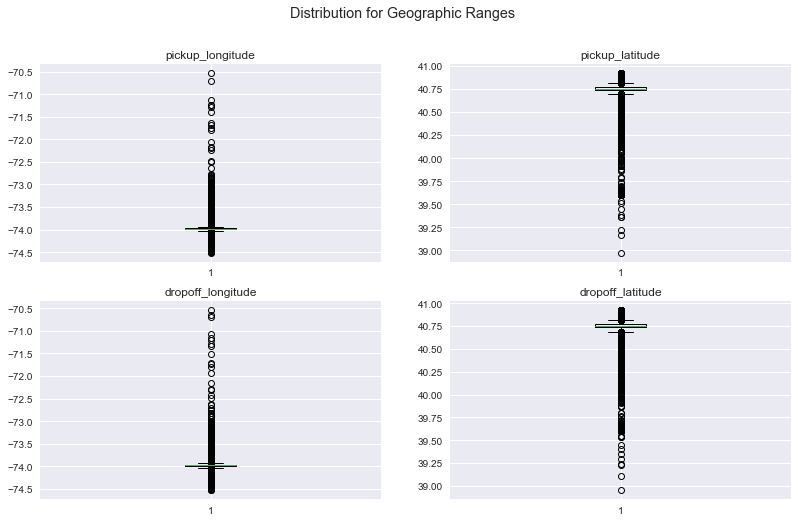

In [33]:
old_len = len(data_p_fixed)
df_geo = data_p_fixed[(data_p_fixed['pickup_longitude'] > (plon_mean-2)) & (data_p_fixed['pickup_longitude'] < (plon_mean+2)) &
                      (data_p_fixed['pickup_latitude'] < (plat_mean+1)) & (data_p_fixed['pickup_latitude'] > (plat_mean-1)) &
                      (data_p_fixed['dropoff_longitude'] > (dlon_mean-2)) & (data_p_fixed['dropoff_longitude'] < (dlon_mean+2)) &
                      (data_p_fixed['dropoff_latitude'] < (dlat_mean+1)) & (data_p_fixed['dropoff_latitude'] > (dlat_mean-1))]
new_len = len(df_geo)
print(f'Dropped {old_len-new_len} geographic extremes')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,8))
fig.suptitle('Distribution for Geographic Ranges')
ax1.boxplot(df_geo['pickup_longitude'])
ax1.set_title('pickup_longitude')
ax2.boxplot(df_geo['pickup_latitude'])
ax2.set_title('pickup_latitude')
ax3.boxplot(df_geo['dropoff_longitude'])
ax3.set_title('dropoff_longitude')
ax4.boxplot(df_geo['dropoff_latitude'])
ax4.set_title('dropoff_latitude')
plt.show()

We still have clear outliers present, but with a much smaller range for our values we will able to be more confident with our models predictions. With the given range, the fare's could be inaccurate if the total distance is far but the fare is low, but we will come back to this if we are having trouble with our model during training.

## Feature Engineering

### Getting total distance traveled
We will use the Haversine formula to find the total distance traveled between pickup and droppoff using the latitude and longitude changes. The idea for this came from this [StackOverflow](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points) article.

In [34]:
def get_total_distance(data):
    '''
    data -- a dataframe containing the longitude and latitude for pickup and dropoff. 
    
    We will calculate the distance between pickup and dropoff to find the total
    distance for a given trip using Haversine formula.
    
    return -- a column to be added to the dataframe
    '''
    distance = []
    
    long1 = np.radians(data['pickup_longitude'].values)
    lat1 = np.radians(data['pickup_latitude'].values)
    long2 = np.radians(data['dropoff_longitude'].values)
    lat2 = np.radians(data['dropoff_latitude'].values)
    
    for i in range(len(data)):
        dlon = np.subtract(long2[i], long1[i])
        dlat = np.subtract(lat2[i], lat1[i])

        a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                            np.multiply(np.cos(lat1[i]), 
                                        np.multiply(np.cos(lat2[i]), 
                                                    np.power(np.sin(np.divide(dlon, 2)), 2))))
        c = np.multiply(2, np.arcsin(np.sqrt(a)))
        r = 6371
        distance.append(c*r)

    return distance

In [35]:
dist_km = get_total_distance(df_geo)

In [69]:
df = df_geo.copy() # create copy of dataframe

In [70]:
df['distance_km'] = dist_km

In [71]:
df = df[df['distance_km'] < 72.42] # keep all distances less than 45 miles

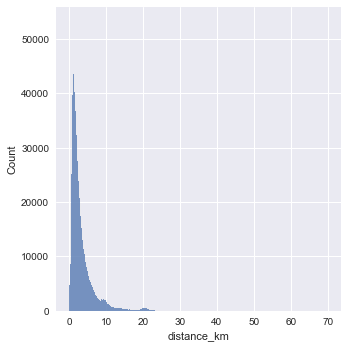

In [72]:
sns.displot(df['distance_km']);

### Extracting Day, Month, and Year

In [74]:
def extract_datetime(df):
    df['date'] = df.pickup_datetime.apply(lambda x: x.split(' ')[0]) # YYYY-MM-DD
    df['hour'] = df.pickup_datetime.apply(lambda x: int(x.split(' ')[1].split(':')[0])) # HH
    df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
    df['day'] = df.date.dt.weekday
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df.drop('date', inplace=True, axis=1)
    df.drop('pickup_datetime', inplace=True, axis=1)
    return df

In [75]:
df = extract_datetime(df)

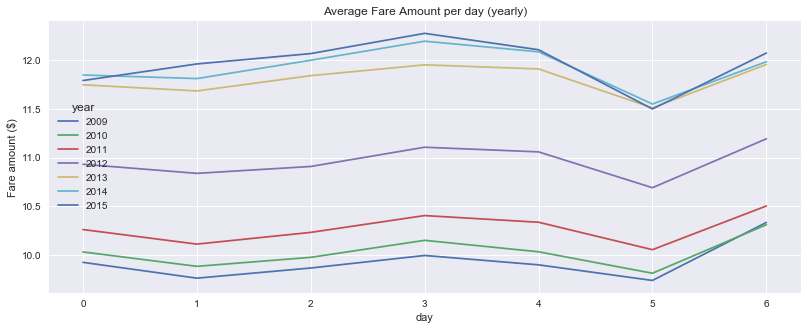

In [83]:
df.pivot_table('fare_amount', index='day', columns='year').plot(figsize = (12,5))
plt.ylabel('Fare amount ($)')
plt.title('Average Fare Amount per day (yearly)');

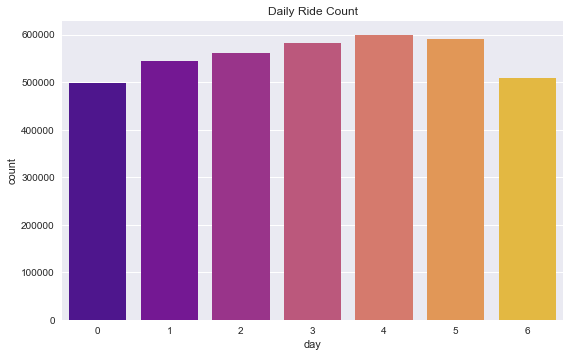

In [93]:
sns.countplot(x='day', data=df, palette='plasma')
plt.title('Daily Ride Count'); 

There is no clear correlation between the day of the week and the price of a taxi ride. We can look further into this by using the hour for each day and finding the average fare by the hour to find a correlation.

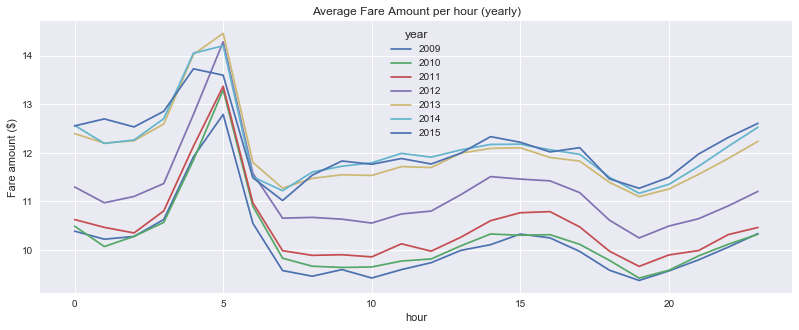

In [82]:
df.pivot_table('fare_amount', index='hour', columns='year').plot(figsize = (12,5))
plt.ylabel('Fare amount ($)')
plt.title('Average Fare Amount per hour (yearly)');

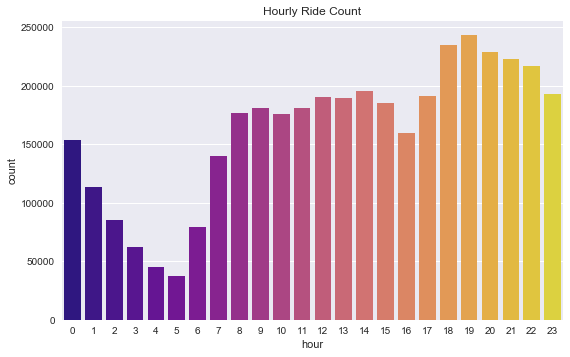

In [91]:
sns.countplot(x='hour', data=df, palette='plasma')
plt.title('Hourly Ride Count');

There seems to be a clear spike in price every day from around 3AM to 5AM, but there also is a drop in the number of rides occuring during this time as well. There also seems to be a drop in fare amount during times of high demand for taxi's from around 5PM to 9PM. There is most likely a correlation between the demand for taxi's and the fare amount (decreased ride amount implies increased fare amount, and vice versa). 

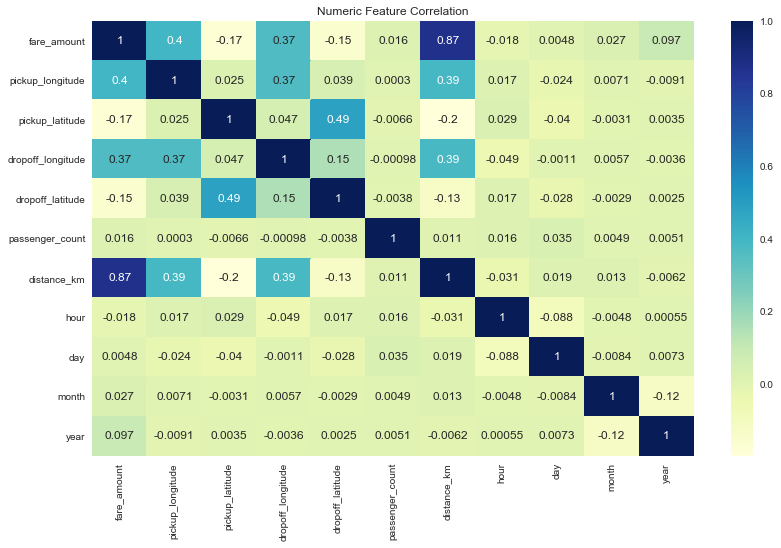

In [84]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.title('Numeric Feature Correlation');

### Format and Save Data
Save changes made to training data to be used for modeling. Format testing data to be in the same form as train data.

In [94]:
df.to_csv('cleaned_train_data.csv', index=False)

In [96]:
test_data['distance_km'] = get_total_distance(test_data)

In [97]:
test_data = extract_datetime(test_data)

In [98]:
test_data.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,hour,day,month,year
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,2.323260,13,1,1,2015
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,13,1,1,2015
2,2011-10-08 11:53:44.0000002,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,11,5,10,2011
3,2012-12-01 21:12:12.0000002,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,21,5,12,2012
4,2012-12-01 21:12:12.0000003,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,21,5,12,2012


In [99]:
test_data.to_csv('formatted_test_data.csv', index=False)